# Generating velocitry models

In this notebook, we generate the synthetic velocity models, Toy model, Marmousi2 model, and 2004 BP model used in our paper. The simulated seismic gathers are generated by RNN-based EFWI module in ***Deepwave***.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from decimal import Decimal
import deepwave
from deepwave import elastic
from scipy.ndimage import gaussian_filter
import warnings
import os
import cv2
warnings.filterwarnings('ignore')

/home/Library/anaconda3/envs/deepwave/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/Library/anaconda3/envs/deepwave/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/Library/anaconda3/envs/deepwave/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/Library/anaconda3/envs/deepwave/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
gpu_count = torch.cuda.device_count()
print(f"The number of available GPUs is: {gpu_count}")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print(f"The selected GPU device is: {torch.cuda.get_device_name(DEVICE)}")
else:
    DEVICE = torch.device("cpu")
    print("No available GPUs detected, switched to using CPU")

The number of available GPUs is: 4
The selected GPU device is: NVIDIA GeForce RTX 3080 Ti


In [3]:
def seed_everything(seed=42):    ###42
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)
def get_dir(directory):
    """
    Creates the given directory if it does not exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory
get_dir("./model")
get_dir("./observed")
def Downsample(img,aim_height,aim_width):
    """
    Downsampling Data
    """
    channel,height,width = img.shape   
    empty_img = torch.zeros((channel,aim_height,aim_width))  
    transform_h = aim_height/height 
    transform_w = aim_width/width   
    for i in range(aim_height):
        for j in range(aim_width):
            x = int(i/transform_h)  
            y = int(j/transform_w)
            empty_img[:,i,j]=img[:,x,y] 
    return empty_img
def Downsample2d(img,aim_height,aim_width):
    height,width = img.shape   
    empty_img = np.zeros((aim_height,aim_width))  
    transform_h = aim_height/height 
    transform_w = aim_width/width   
    for i in range(aim_height):
        for j in range(aim_width):
            x = int(i/transform_h)  
            y = int(j/transform_w)
            empty_img[i,j]=img[x,y] 
    return empty_img
def awgn(signal,std):
    """
    Add noise to the signal using SNR.
    
    """
    noise_variance = std**2
    noise = np.random.normal(0, np.sqrt(noise_variance), signal.shape)
    signal_noise = signal + noise
    
    return signal_noise

## 1.1 Toy model

In [4]:
toy_vp = np.zeros((128, 256))
toy_vp[:80, :] = 1700
toy_vp[80:, :] = 3000

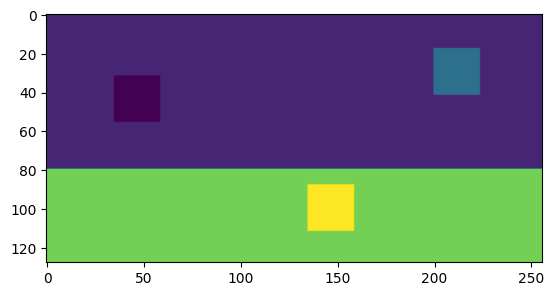

In [5]:
toy_vp = np.zeros((128, 256))
toy_vp[:80, :] = 1700
toy_vp[80:, :] = 3000
torch.save(torch.tensor(toy_vp).float(),'./model/toy_vp_init')
abnormal_size = 24
Square_start1 = (32,35)
toy_vp[Square_start1[0]:Square_start1[0]+24, Square_start1[1]:Square_start1[1]+abnormal_size] = 1500
Square_start2 = (18,200)
toy_vp[Square_start2[0]:Square_start2[0]+24, Square_start2[1]:Square_start2[1]+abnormal_size] = 2200
Square_start3 = (88,135)
toy_vp[Square_start3[0]:Square_start3[0]+24, Square_start3[1]:Square_start3[1]+abnormal_size] = 3400
plt.imshow(toy_vp)
torch.save(torch.tensor(toy_vp).float(),'./model/toy_vp')

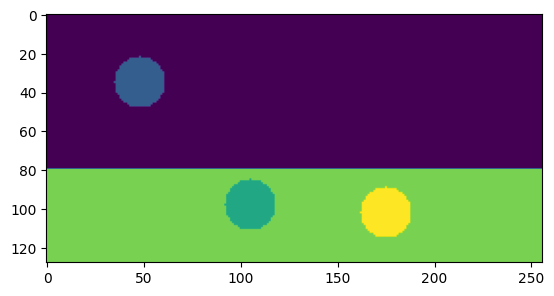

In [6]:
def plot_filled_circle(vp, x_center, y_center, radius,value):
    for i in range(max(0, y_center - radius), min(vp.shape[0], y_center + radius)):
        for j in range(max(0, x_center - radius), min(vp.shape[1], x_center + radius)):
            if (i - y_center)**2 + (j - x_center)**2 <= radius**2:
                vp[i, j] = value
    return vp
toy_vs = np.zeros((128, 256))
toy_vs[:80, :] = 900
toy_vs[80:, :] = 1700
torch.save(torch.tensor(toy_vs).float(),'./model/toy_vs_init')
radius = 13
circle_center1 = (48,35)
plot_filled_circle(toy_vs, circle_center1[0], circle_center1[1], radius,1200)
circle_center2 = (105,98)
plot_filled_circle(toy_vs, circle_center2[0], circle_center2[1], radius,1500)
circle_center3 = (175,102)
plot_filled_circle(toy_vs, circle_center3[0], circle_center3[1], radius,1900)
plt.imshow(toy_vs)
torch.save(torch.tensor(toy_vs).float(),'./model/toy_vs')

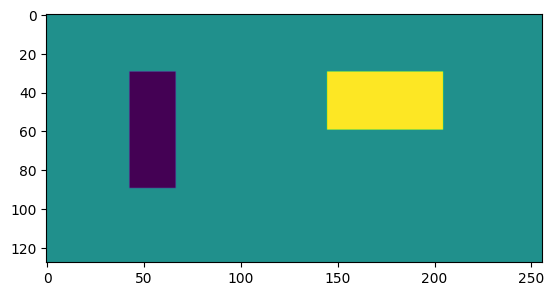

In [7]:
toy_rho = np.zeros((128, 256)) + 1000
torch.save(torch.tensor(toy_rho).float(),'./model/toy_rho_init')
rectangular_prism1 = (30,43)
rectangular_prism2 = (30,145)
toy_rho[rectangular_prism1[0]:rectangular_prism1[0]+60, rectangular_prism1[1]:rectangular_prism1[1]+24] = 900
toy_rho[rectangular_prism2[0]:rectangular_prism2[0]+30, rectangular_prism2[1]:rectangular_prism2[1]+60] = 1100
plt.imshow(toy_rho)
torch.save(torch.tensor(toy_rho).float(),'./model/toy_rho')

## 1.2 Generating seismic gathers of Toy model

In [8]:
model_shape = [128, 256]                                 

NOISE: int = 0                                        
T = 2.4                                               
DT = 0.006                                            
F_PEAK = 10                                           
DH = 5                                                
N_SHOTS = 20                                          
N_SOURCE_PER_SHOT = 1                                 

MODEL_INPUT_SIZE = 401                                  
DEEPWAVE_SIZE = 401                                      

inpa = {  
    'ns': N_SHOTS,        
    'sdo': 4,                                            
    'fdom': F_PEAK, 
    'dh': DH,   
    'dt': DT,  
    'acq_type': 1,                                      
    't': T, 
    'npml': 20,                                         
    'pmlR': 1e-5,                                       
    'pml_dir': 2,                                       
    'device': 1,                                        
    'seimogram_shape': '3d',                            
    'energy_balancing': False,
    "chpr": 70,    
}

t_in = str(inpa['t'])
dt_in = str(inpa["dt"])
NT = int( Decimal(t_in) // Decimal(dt_in)  + 1)
print("NT:",NT)
inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance

offsetx = inpa['dh'] * model_shape[1]
print("offsetx:",offsetx)
depth = inpa['dh'] * model_shape[0]
print("depth:",depth)
surface_loc_x = np.arange(28*inpa["dh"], offsetx-28*inpa["dh"], inpa['dh'], np.float32)      

n_surface_rec = len(surface_loc_x)

surface_loc_z = 5 * inpa["dh"] * np.ones(n_surface_rec, np.float32)         

surface_loc = np.vstack((surface_loc_x, surface_loc_z)).T


rec_loc_temp = surface_loc

src_loc_temp = np.vstack((
    np.linspace(28*inpa["dh"], offsetx-28*inpa["dh"], N_SHOTS, np.float32),     
    2 * inpa["dh"] * np.ones(N_SHOTS, np.float32)
    )).T

src_loc_temp[:, 1] -= 2 * inpa['dh']
# Create the source
N_RECEIVERS = n_surface_rec 
print('N_RECEIVERS:',N_RECEIVERS)
    
# Shot 1 source located at cell [0, 1], shot 2 at [0, 2], shot 3 at [0, 3]
src_loc = torch.zeros(N_SHOTS, N_SOURCE_PER_SHOT, 2,
                        dtype=torch.int, device=DEVICE)

src_loc[:, 0, :] = torch.Tensor(np.flip(src_loc_temp) // DH)

src_loc[:,:,0] = 1

# Receivers located at [0, 1], [0, 2], ... for every shot
rec_loc = torch.zeros(N_SHOTS, N_RECEIVERS, 2,
                        dtype=torch.long, device=DEVICE)
rec_loc[:, :, :] = (
    torch.Tensor(np.flip(rec_loc_temp)/DH)
    ) 
src = (
    deepwave.wavelets.ricker(F_PEAK, NT, DT, 1.5 / F_PEAK)
    .repeat(N_SHOTS, N_SOURCE_PER_SHOT, 1)
    .to(DEVICE)
    ) 
print('wavelets shape:',src.shape)

obs_path = "observed/toy_gather/"                
get_dir(obs_path)

NT: 401
offsetx: 1280
depth: 640
N_RECEIVERS: 200
wavelets shape: torch.Size([20, 1, 401])


'observed/toy_gather/'

Number of 
----------
sources: 20
receivers: 200
obsvx shape:torch.Size([20, 401, 200])
obsvy shape:torch.Size([20, 401, 200])


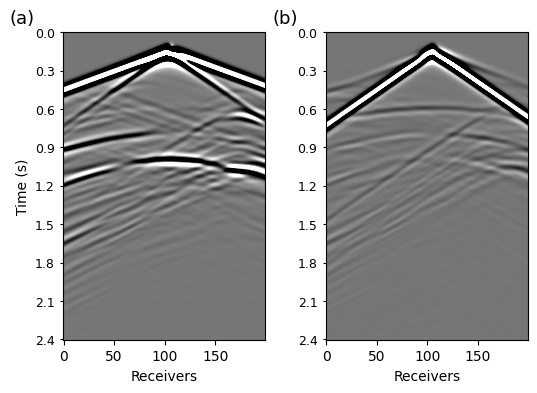

In [9]:
toy_vp = torch.tensor(toy_vp).float().to(DEVICE)
toy_vs = torch.tensor(toy_vs).float().to(DEVICE)
toy_rho = torch.tensor(toy_rho).float().to(DEVICE)

out = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(toy_vp, toy_vs,
                                               toy_rho),
    DH, DT,
    source_amplitudes_y=src,
    source_amplitudes_x=src,
    source_locations_y=src_loc,
    source_locations_x=src_loc,
    receiver_locations_y=rec_loc,
    receiver_locations_x=rec_loc,
    pml_freq=F_PEAK,
)

vx = out[15]
vx_label = Downsample(vx,N_RECEIVERS,DEEPWAVE_SIZE)
vx_input = Downsample(vx,N_RECEIVERS,MODEL_INPUT_SIZE)
vy = out[14]
vy_label = Downsample(vy,N_RECEIVERS,DEEPWAVE_SIZE)
vy_input = Downsample(vy,N_RECEIVERS,MODEL_INPUT_SIZE)

taux_vx = (vx_label.cpu()).permute(0, 2, 1)
taux_vy = (vy_label.cpu()).permute(0, 2, 1)
taux_input_vx = (vx_input.cpu()).permute(0, 2, 1)
taux_input_vy = (vy_input.cpu()).permute(0, 2, 1)

if taux_vx.shape==taux_vy.shape:
    ns, nt, nr = taux_vx.shape
    print(f"Number of \n{'-'*10}")
    print(f"sources: {ns}\nreceivers: {nr}\nobsvx shape:{taux_vx.shape}\nobsvy shape:{taux_vy.shape}")
    if NOISE:
        taux_vx = awgn(taux_vx, NOISE)
        taux_vy = awgn(taux_vy, NOISE)
        print("Noise added")
        
    vpmin, vpmax = torch.quantile(taux_vx[N_SHOTS//2],
                                 torch.tensor([0.01, 0.99]))
    vsmin, vsmax = torch.quantile(taux_vy[N_SHOTS//2],
                                 torch.tensor([0.01, 0.99]))

gain = 0.3
torch.save(taux_vx,f= obs_path + f"/obs_vx_{N_SHOTS}_{F_PEAK}_{NT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vx,f= obs_path + f"/input_vx_{N_SHOTS}_{F_PEAK}_{NT}_{MODEL_INPUT_SIZE}")
torch.save(taux_vy,f= obs_path + f"/obs_vy_{N_SHOTS}_{F_PEAK}_{NT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vy,f= obs_path + f"/input_vy_{N_SHOTS}_{F_PEAK}_{MODEL_INPUT_SIZE}")
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(taux_vx[N_SHOTS//2], aspect='auto', cmap='gray',vmin=gain*vpmin, vmax=gain*vpmax)
ax[0].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[0].set_xlabel("Receivers")
ax[0].set_ylabel("Time (s)")
ax[0].set_title('(a)',position=(-0.2,1),fontsize=13)
ax[1].imshow(taux_vy[N_SHOTS//2], aspect='auto', cmap='gray',vmin=gain*vsmin, vmax=gain*vsmax)
ax[1].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[1].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[1].set_xlabel("Receivers")
ax[1].set_title('(b)',position=(-0.2,1),fontsize=13)
plt.subplots_adjust(hspace=0.6,wspace=0.3) 
plt.savefig(obs_path+"records.pdf",bbox_inches='tight', dpi=900)  
plt.show()

## 2.1 The Marmousi2 model

(174, 450) (174, 450) (173, 450)


[]

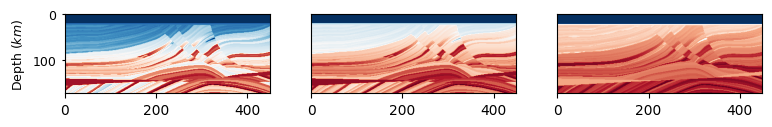

In [10]:
raw_marmousi2_vp = np.flipud(torch.load('./raw_model/raw_marmousi2_vp'))[:,:450]
raw_marmousi2_vs = np.flipud(torch.load('./raw_model/raw_marmousi2_vs'))[:,:450]  
raw_marmousi2_rho = np.flipud(torch.load('./raw_model/raw_marmousi2_rho'))[1:,:450]  
raw_marmousi2_rho[:22,:] = 1009
print(raw_marmousi2_vp.shape,raw_marmousi2_vs.shape,raw_marmousi2_rho.shape)
VP_MIN = raw_marmousi2_vp.min().item()
VP_MAX = raw_marmousi2_vp.max().item()
VS_MIN = raw_marmousi2_vs.min().item()
VS_MAX = raw_marmousi2_vs.max().item()
RHO_MIN = raw_marmousi2_rho.min().item()
RHO_MAX = raw_marmousi2_rho.max().item()

fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig0 = ax[0].imshow(raw_marmousi2_vp, cmap= 'RdBu_r')
ax[0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[0].set_ylabel("Depth ($km$)",fontsize=9)
fig0 = ax[1].imshow(raw_marmousi2_vs, cmap= 'RdBu_r')
ax[1].set_yticks([])
fig2 = ax[2].imshow(raw_marmousi2_rho, cmap= 'RdBu_r')
ax[2].set_yticks([])

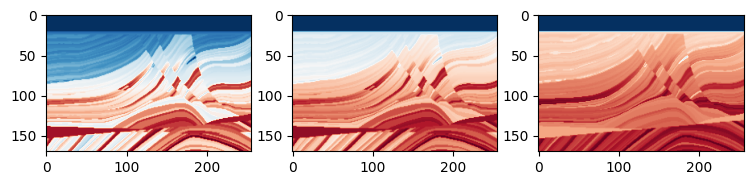

In [11]:
image = [raw_marmousi2_vp,raw_marmousi2_vs,raw_marmousi2_rho]
data = []
target_width = 256
target_height = 170
for i in range(len(image)):
    downsampled_image = cv2.resize(image[i], (target_width, target_height), interpolation=cv2.INTER_AREA)
    data.append(downsampled_image)
VP_MIN = data[0].min().item()
VP_MAX = data[0].max().item()
VS_MIN = data[1].min().item()
VS_MAX = data[1].max().item()
RHO_MIN = data[2].min().item()
RHO_MAX = data[2].max().item()

fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig0 = ax[0].imshow(data[0], cmap= 'RdBu_r')
fig0 = ax[1].imshow(data[1], cmap= 'RdBu_r')
fig2 = ax[2].imshow(data[2], cmap= 'RdBu_r')

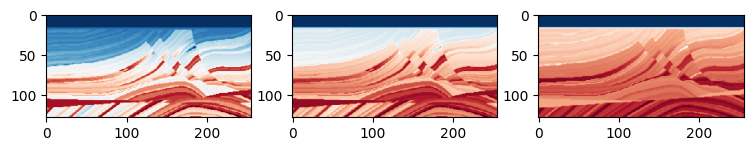

In [12]:
data_downsample = []
for j in range(len(image)):
   downsample_data = Downsample2d(data[j],128,256)
   data_downsample.append(downsample_data)
marmousi2_vp = data_downsample[0]
marmousi2_vs = data_downsample[1]
marmousi2_rho = data_downsample[2]
fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig0 = ax[0].imshow(marmousi2_vp, cmap= 'RdBu_r')
fig0 = ax[1].imshow(marmousi2_vs, cmap= 'RdBu_r')
fig2 = ax[2].imshow(marmousi2_rho, cmap= 'RdBu_r')
torch.save(torch.tensor(marmousi2_vp).float(),"./model/marmousi2_vp")
torch.save(torch.tensor(marmousi2_vs).float(),"./model/marmousi2_vs")
torch.save(torch.tensor(marmousi2_rho).float(),"./model/marmousi2_rho")

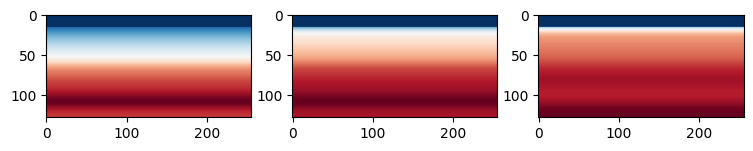

In [13]:
mean_data = []
name = ['vp','vs','rho']
for r in range(len(image)):
    a_mean = np.mean(data_downsample[r],axis=1, keepdims=True)
    a_initial = np.tile(a_mean, (1, target_width))
    a_initial = gaussian_filter(a_initial, sigma=5)
    if str(name[r])=="vp":
        a_initial[:16,:] = 1500
    if str(name[r])=="vs":
        a_initial[:16,:] = 0
    if str(name[r])=="rho":
        a_initial[:16,:] = 1009
    mean_data.append(a_initial)
    torch.save(torch.tensor(a_initial).float(),f'./model/marmousi2_{str(name[r])}init')
marmousi2_vpinit = mean_data[0]
marmousi2_vsinit = mean_data[1]
marmousi2_rhoinit = mean_data[2]
VP_MIN = marmousi2_vpinit.min().item()
VP_MAX = marmousi2_vpinit.max().item()
VS_MIN = marmousi2_vsinit.min().item()
VS_MAX = marmousi2_vsinit.max().item()
RHO_MIN = marmousi2_rhoinit.min().item()
RHO_MAX = marmousi2_rhoinit.max().item()
fig, ax = plt.subplots(1, 3, figsize=(9, 12))
fig0 = ax[0].imshow(marmousi2_vpinit, cmap= 'RdBu_r')
fig0 = ax[1].imshow(marmousi2_vsinit, cmap= 'RdBu_r')
fig2 = ax[2].imshow(marmousi2_rhoinit, cmap= 'RdBu_r')


## 2.2 Generating seismic gathers of the Marmousi2 model

In [14]:
model_shape = [128,256] 

NOISE: float = 0.5                                   
T = 2.4                                              
DT = 0.006                                           
F_PEAK = 10                                          
DH = 10                                              
N_SHOTS = 20                                         
N_SOURCE_PER_SHOT = 1                                


MODEL_INPUT_SIZE = 401                               
DEEPWAVE_SIZE = 401                                  

inpa = {  
    'ns': N_SHOTS,        
    'sdo': 4,                                        
    'fdom': F_PEAK, 
    'dh': DH,   
    'dt': DT,  
    'acq_type': 1,                                   
    't': T, 
    'npml': 20,                                      
    'pmlR': 1e-5,                                    
    'pml_dir': 2,                                    
    'device': 1,                                     
    'seimogram_shape': '3d',                         
    'energy_balancing': False, 
    "chpr": 70,    
}

t_in = str(inpa['t'])
dt_in = str(inpa["dt"])
NT = int( Decimal(t_in) // Decimal(dt_in)  + 1)
print("NT:",NT)
inpa['rec_dis'] =  1 * inpa['dh']  

offsetx = inpa['dh'] * model_shape[1]
print("offsetx:",offsetx)
depth = inpa['dh'] * model_shape[0]
print("depth:",depth)
surface_loc_x = np.arange(13*inpa["dh"], offsetx-13*inpa["dh"], inpa['dh'], np.float32)      
n_surface_rec = len(surface_loc_x)
print('n_surface_rec',n_surface_rec)

surface_loc_z = 17 * inpa["dh"] * np.ones(n_surface_rec, np.float32)        

surface_loc = np.vstack((surface_loc_x, surface_loc_z)).T

rec_loc_temp = surface_loc

src_loc_temp = np.vstack((
    np.linspace(13*inpa["dh"], offsetx-13*inpa["dh"], N_SHOTS, np.float32),    
    2 * inpa["dh"] * np.ones(N_SHOTS, np.float32)
    )).T

src_loc_temp[:, 1] -= 2 * inpa['dh']
# Create the source
N_RECEIVERS = n_surface_rec 
print('N_RECEIVERS:',N_RECEIVERS)
    
# Shot 1 source located at cell [0, 1], shot 2 at [0, 2], shot 3 at [0, 3]
src_loc = torch.zeros(N_SHOTS, N_SOURCE_PER_SHOT, 2,
                        dtype=torch.int, device=DEVICE)

src_loc[:, 0, :] = torch.Tensor(np.flip(src_loc_temp) // DH)

src_loc[:,:,0] = 1

# Receivers located at [0, 1], [0, 2], ... for every shot
rec_loc = torch.zeros(N_SHOTS, N_RECEIVERS, 2,
                        dtype=torch.long, device=DEVICE)
rec_loc[:, :, :] = (
    torch.Tensor(np.flip(rec_loc_temp)/DH)
    ) 
src = (
    deepwave.wavelets.ricker(F_PEAK, NT, DT, 1.5 / F_PEAK)
    .repeat(N_SHOTS, N_SOURCE_PER_SHOT, 1)
    .to(DEVICE)
    ) 
print('wavelets shape:',src.shape)


obs_path = "observed/marmousi2_gather/noise0.5"                
get_dir(obs_path)

NT: 401
offsetx: 2560
depth: 1280
n_surface_rec 230
N_RECEIVERS: 230
wavelets shape: torch.Size([20, 1, 401])


'observed/marmousi2_gather/noise0.5'

Number of 
----------
sources: 20
receivers: 230
obsvx shape:torch.Size([20, 401, 230])
obsvy shape:torch.Size([20, 401, 230])
Noise added 0.5 $\sigma_0$
torch.Size([20, 401, 230])


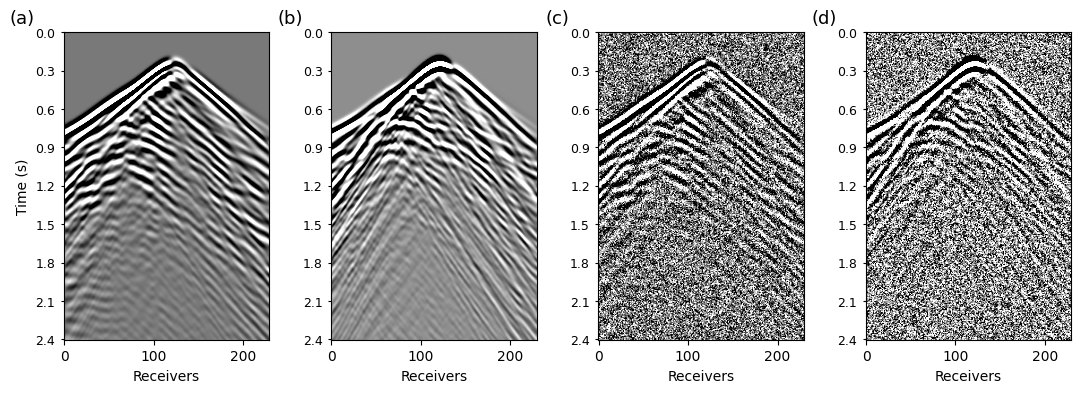

In [15]:
marmousi2_vp = torch.tensor(marmousi2_vp).float().to(DEVICE)
marmousi2_vs = torch.tensor(marmousi2_vs).float().to(DEVICE)
marmousi2_rho = torch.tensor(marmousi2_rho).float().to(DEVICE)

out = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(marmousi2_vp, marmousi2_vs,
                                               marmousi2_rho),
    DH, DT,
    source_amplitudes_y=src,
    source_amplitudes_x=src,
    source_locations_y=src_loc,
    source_locations_x=src_loc,
    receiver_locations_y=rec_loc,
    receiver_locations_x=rec_loc,
    pml_freq=F_PEAK,
)

vx = out[15]
vy = out[14]


taux_vx = (vx.cpu()).permute(0, 2, 1)
taux_vy = (vy.cpu()).permute(0, 2, 1)
taux_input_vx = (vx.cpu()).permute(0, 2, 1)
taux_input_vy = (vy.cpu()).permute(0, 2, 1)

if taux_vx.shape==taux_vy.shape:
    ns, nt, nr = taux_vx.shape
    print(f"Number of \n{'-'*10}")
    print(f"sources: {ns}\nreceivers: {nr}\nobsvx shape:{taux_vx.shape}\nobsvy shape:{taux_vy.shape}")
    if NOISE:
        std_vx = np.std(taux_vx.numpy())*2
        std_vy = np.std(taux_vy.numpy())*2
        std_input_vx = np.std(taux_input_vx.numpy())*2
        std_input_vy = np.std(taux_input_vy.numpy())*2

        taux_vx_noise = awgn(taux_vx, NOISE*std_vx)
        taux_vy_noise = awgn(taux_vy, NOISE*std_vy)
        taux_input_vx_noise = awgn(taux_input_vx, NOISE*std_input_vx)
        taux_input_vy_noise = awgn(taux_input_vy, NOISE*std_input_vy)
        print(f"Noise added {NOISE} $\sigma_0$")
        
    vpmin, vpmax = torch.quantile(taux_vx[N_SHOTS//2],
                                torch.tensor([0.01, 0.99]))
    vsmin, vsmax = torch.quantile(taux_vy[N_SHOTS//2],
                                torch.tensor([0.01, 0.99]))


print(taux_vx.shape)
torch.save(taux_vx,f= obs_path + f"/clean_obs_vx_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vx,f= obs_path + f"/clean_input_vx_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{MODEL_INPUT_SIZE}")
torch.save(taux_vy,f= obs_path + f"/clean_obs_vy_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vy,f= obs_path + f"/clean_input_vy_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{MODEL_INPUT_SIZE}")

torch.save(taux_vx_noise,f= obs_path + f"/noise{NOISE}_obs_vx_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vx_noise,f= obs_path + f"/noise{NOISE}_input_vx_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{MODEL_INPUT_SIZE}")
torch.save(taux_vy_noise,f= obs_path + f"/noise{NOISE}_obs_vy_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vy_noise,f= obs_path + f"/noise{NOISE}_input_vy_{N_SHOTS}_{F_PEAK}_{T}_{DT}_{MODEL_INPUT_SIZE}")
gain = 0.3
fig, ax = plt.subplots(1, 4, figsize=(13, 4))
ax[0].imshow(taux_vx[N_SHOTS//2].cpu(), aspect='auto', cmap='gray',vmin=gain*vpmin, vmax=gain*vpmax)
ax[0].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[0].set_xlabel("Receivers")
ax[0].set_ylabel("Time (s)")
ax[0].set_title('(a)',position=(-0.2,1),fontsize=13)
ax[1].imshow(taux_vy[N_SHOTS//2].cpu(), aspect='auto', cmap='gray',vmin=gain*vsmin, vmax=gain*vsmax)   
ax[1].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[1].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[1].set_xlabel("Receivers")
ax[1].set_title('(b)',position=(-0.2,1),fontsize=13)
ax[2].imshow(taux_vx_noise[N_SHOTS//2].cpu(), aspect='auto', cmap='gray',vmin=gain*vpmin, vmax=gain*vpmax)
ax[2].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[2].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[2].set_xlabel("Receivers")
#ax[2].set_ylabel("Time (s)")
ax[2].set_title('(c)',position=(-0.2,1),fontsize=13)
ax[3].imshow(taux_vy_noise[N_SHOTS//2].cpu(), aspect='auto', cmap='gray',vmin=gain*vsmin, vmax=gain*vsmax)  
ax[3].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[3].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[3].set_xlabel("Receivers")
ax[3].set_title('(d)',position=(-0.2,1),fontsize=13)
#ax[1].set_ylabel("Time (s)\n")
plt.subplots_adjust(hspace=0.6,wspace=0.3) 
plt.savefig(obs_path+f"/records_clean$noise{NOISE}"+".pdf",bbox_inches='tight', dpi=900)  
plt.show()

## 3.2 The 2004 BP model

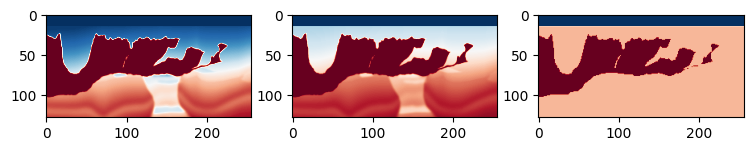

In [16]:
target_width = 256
target_height = 128

raw_bp_vp = torch.load("./raw_model/raw_bp_vp")
bp_vp = cv2.resize(np.array(raw_bp_vp), (target_width, target_height), interpolation=cv2.INTER_AREA)

raw_bp_vs = torch.load("./raw_model/raw_bp_vs")
bp_vs = cv2.resize(np.array(raw_bp_vs), (target_width, target_height), interpolation=cv2.INTER_AREA)

raw_bp_rho = torch.load("./raw_model/raw_bp_rho")
bp_rho = cv2.resize(np.array(raw_bp_rho), (target_width, target_height), interpolation=cv2.INTER_AREA)
fig, ax = plt.subplots(1, 3, figsize=(9, 12))
ax[0].imshow(bp_vp,cmap="RdBu_r")
ax[1].imshow(bp_vs,cmap="RdBu_r")
ax[2].imshow(bp_rho,cmap="RdBu_r")                            

### bp smooth initial model

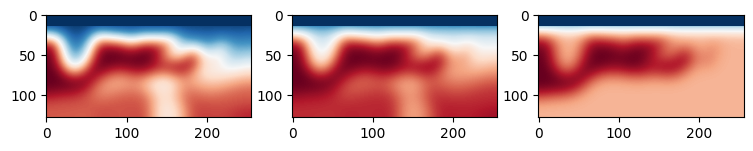

In [17]:
submarine_deep = 15
bp_vpinit_smooth = gaussian_filter(bp_vp, sigma=10)
bp_vpinit_smooth[:submarine_deep,:] = bp_vp[:submarine_deep,:]
bp_vsinit_smooth = gaussian_filter(bp_vs, sigma=10)
bp_vsinit_smooth[:submarine_deep,:] = bp_vs[:submarine_deep,:]
bp_rhoinit_smooth = gaussian_filter(bp_rho, sigma=10)
bp_rhoinit_smooth[:submarine_deep,:] = bp_rho[:submarine_deep,:]
fig, ax = plt.subplots(1, 3, figsize=(9, 12))
ax[0].imshow(bp_vpinit_smooth,cmap="RdBu_r")
ax[1].imshow(bp_vsinit_smooth,cmap="RdBu_r")
ax[2].imshow(bp_rhoinit_smooth,cmap="RdBu_r") 
torch.save(torch.tensor(bp_vpinit_smooth).float(),"./model/bp_vpinit_smooth")
torch.save(torch.tensor(bp_vsinit_smooth).float(),"./model/bp_vsinit_smooth")
torch.save(torch.tensor(bp_rhoinit_smooth).float(),"./model/bp_rhoinit_smooth")

### bp 1d smooth initial model

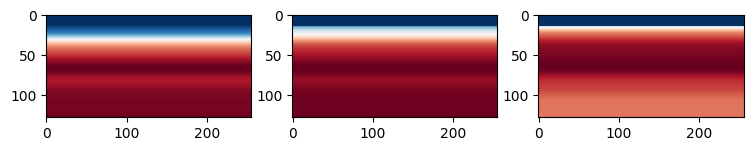

In [18]:
bp_vp_mean = np.mean(bp_vp,axis=1, keepdims=True)
bp_vs_mean = np.mean(bp_vs,axis=1, keepdims=True)
bp_rho_mean = np.mean(bp_rho,axis=1, keepdims=True)

bp_vpinit_1d = np.tile(bp_vp_mean , (1,bp_vp.shape[1]))
bp_vsinit_1d = np.tile(bp_vs_mean, (1,bp_vs.shape[1]))
bp_rhoinit_1d = np.tile(bp_rho_mean, (1,bp_rho.shape[1]))

bp_vpinit_1dsmooth = gaussian_filter(bp_vpinit_1d, sigma=5)
bp_vpinit_1dsmooth[:submarine_deep,:] = bp_vp[:submarine_deep,:]
bp_vsinit_1dsmooth = gaussian_filter(bp_vsinit_1d, sigma=5)
bp_vsinit_1dsmooth[:submarine_deep,:] = bp_vs[:submarine_deep,:]
bp_rhoinit_1dsmooth = gaussian_filter(bp_rhoinit_1d, sigma=5)
bp_rhoinit_1dsmooth[:submarine_deep,:] = bp_rho[:submarine_deep,:]

fig, ax = plt.subplots(1, 3, figsize=(9, 12))
ax[0].imshow(bp_vpinit_1dsmooth,cmap="RdBu_r")
ax[1].imshow(bp_vsinit_1dsmooth,cmap="RdBu_r")
ax[2].imshow(bp_rhoinit_1dsmooth,cmap="RdBu_r")
torch.save(torch.tensor(bp_vpinit_1dsmooth).float(),"./model/bp_vpinit_1dsmooth")
torch.save(torch.tensor(bp_vsinit_1dsmooth).float(),"./model/bp_vsinit_1dsmooth")
torch.save(torch.tensor(bp_rhoinit_1dsmooth).float(),"./model/bp_rhoinit_1dsmooth")

### bp homogeneous inital model

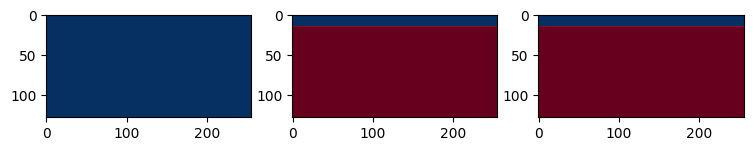

In [19]:
bp_vpinit_homogeneous = np.zeros(bp_vp.shape) + 1500
bp_vpinit_homogeneous[:submarine_deep,:] = bp_vp[:submarine_deep,:]
bp_vsinit_homogeneous = np.zeros(bp_vs.shape) + 1200
bp_vsinit_homogeneous[:submarine_deep,:] = bp_vs[:submarine_deep,:]
bp_rhoinit_homogeneous = np.zeros(bp_rho.shape) + 1800
bp_rhoinit_homogeneous[:submarine_deep,:] = bp_rho[:submarine_deep,:]

fig, ax = plt.subplots(1, 3, figsize=(9, 12))
ax[0].imshow(bp_vpinit_homogeneous,cmap="RdBu_r")
ax[1].imshow(bp_vsinit_homogeneous,cmap="RdBu_r")
ax[2].imshow(bp_rhoinit_homogeneous,cmap="RdBu_r") 

torch.save(torch.tensor(bp_vpinit_homogeneous).float(),"./model/bp_vpinit_homogeneous")
torch.save(torch.tensor(bp_vsinit_homogeneous).float(),"./model/bp_vsinit_homogeneous")
torch.save(torch.tensor(bp_rhoinit_homogeneous).float(),"./model/bp_rhoinit_homogeneous")

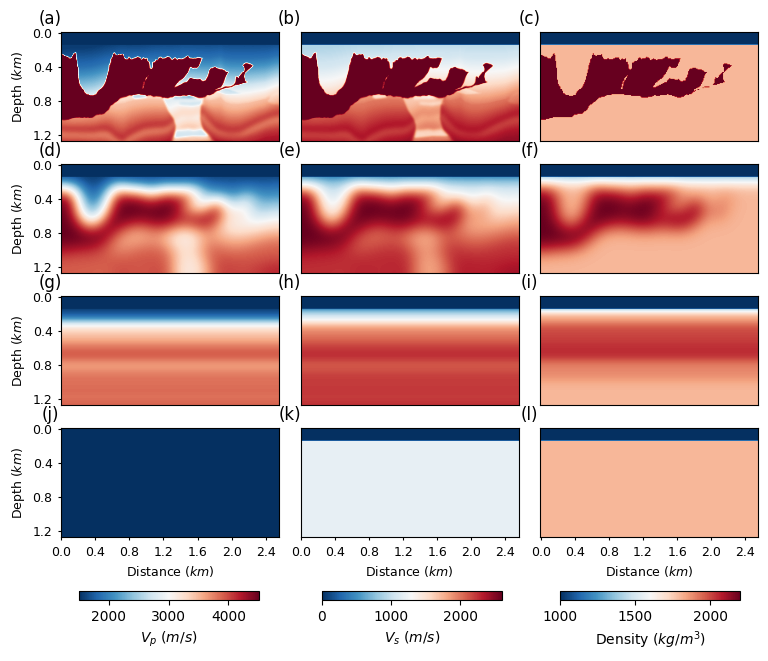

In [20]:
VP_MIN = bp_vp.min().item()
VP_MAX = bp_vp.max().item()
VS_MIN = bp_vs.min().item()
VS_MAX = bp_vs.max().item()
RHO_MIN = bp_rho.min().item()
RHO_MAX = bp_rho.max().item()
DH = 10
fig, ax = plt.subplots(4, 3, figsize=(9, 12))
fig0 = ax[0,0].imshow(bp_vp, cmap= 'RdBu_r',vmin=VP_MIN,vmax=VP_MAX)
ax[0,0].tick_params(axis='x', which='both',labelleft=True , labelbottom=False)
ax[0,0].set_xticks([])
ax[0,0].set_yticks(np.arange(0,bp_vp.shape[0],40),(DH*np.arange(0,bp_vp.shape[0],40))/1000)
ax[0,0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[0,0].set_ylabel("Depth ($km$)",fontsize=9)
 

fig1 = ax[0,1].imshow(bp_vs, cmap= 'RdBu_r',vmin=VS_MIN,vmax=VS_MAX)
ax[0,1].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[0,1].set_xticks([])
ax[0,1].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[0,1].set_yticks([])

fig2 = ax[0,2].imshow(bp_rho, cmap= 'RdBu_r',vmin=RHO_MIN,vmax=RHO_MAX)
ax[0,2].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[0,2].set_xticks([])
ax[0,2].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[0,2].set_yticks([])
##############################################################################################################
fig0 = ax[1,0].imshow(bp_vpinit_smooth, cmap= 'RdBu_r',vmin=VP_MIN,vmax=VP_MAX)
ax[1,0].tick_params(axis='x', which='both',labelleft=True , labelbottom=False)
ax[1,0].set_xticks([])
ax[1,0].set_yticks(np.arange(0,bp_vp.shape[0],40),(DH*np.arange(0,bp_vp.shape[0],40))/1000)
ax[1,0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[1,0].set_ylabel("Depth ($km$)",fontsize=9)

fig1 = ax[1,1].imshow(bp_vsinit_smooth, cmap= 'RdBu_r',vmin=VS_MIN,vmax=VS_MAX)
ax[1,1].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[1,1].set_xticks([])
ax[1,1].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[1,1].set_yticks([])

fig2 = ax[1,2].imshow(bp_rhoinit_smooth, cmap= 'RdBu_r',vmin=RHO_MIN,vmax=RHO_MAX)
ax[1,2].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[1,2].set_xticks([])
ax[1,2].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[1,2].set_yticks([])
#############################################################################################################
fig0 = ax[2,0].imshow(bp_vpinit_1dsmooth, cmap= 'RdBu_r',vmin=VP_MIN,vmax=VP_MAX)
ax[2,0].tick_params(axis='x', which='both',labelleft=True , labelbottom=False)
ax[2,0].set_xticks([])
ax[2,0].set_yticks(np.arange(0,bp_vp.shape[0],40),(DH*np.arange(0,bp_vp.shape[0],40))/1000)
ax[2,0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[2,0].set_ylabel("Depth ($km$)",fontsize=9)
 

fig1 = ax[2,1].imshow(bp_vsinit_1dsmooth, cmap= 'RdBu_r',vmin=VS_MIN,vmax=VS_MAX)
ax[2,1].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[2,1].set_xticks([])
ax[2,1].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[2,1].set_yticks([])

fig2 = ax[2,2].imshow(bp_rhoinit_1dsmooth, cmap= 'RdBu_r',vmin=RHO_MIN,vmax=RHO_MAX)
ax[2,2].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[2,2].set_xticks([])
ax[2,2].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[2,2].set_yticks([])
##########################################################################################################

fig0 = ax[3,0].imshow(bp_vpinit_homogeneous, cmap= 'RdBu_r',vmin=VP_MIN,vmax=VP_MAX)
ax[3,0].set_yticks(np.arange(0,bp_vp.shape[0],40),(DH*np.arange(0,bp_vp.shape[0],40))/1000)
ax[3,0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[3,0].set_xticks(np.arange(0,bp_vp.shape[1],40),(DH*np.arange(0,bp_vp.shape[1],40))/1000)
ax[3,0].tick_params(axis='x', which='both', length=2.5, labelsize=9)
ax[3,0].set_xlabel("Distance ($km$)",fontsize=9)
ax[3,0].set_ylabel("Depth ($km$)",fontsize=9)

fig1 = ax[3,1].imshow(bp_vsinit_homogeneous, cmap= 'RdBu_r',vmin=VS_MIN,vmax=VS_MAX)
ax[3,1].set_yticks([])
ax[3,1].tick_params(axis='x', which='both', labelbottom=True)
ax[3,1].tick_params(axis='y', which='both', labelleft=False)
ax[3,1].set_xticks(np.arange(0,bp_vp.shape[1],40),(DH*np.arange(0,bp_vp.shape[1],40))/1000)
ax[3,1].tick_params(axis='x', which='both', length=2.5, labelsize=9)
ax[3,1].set_xlabel("Distance ($km$)",fontsize=9)

fig2 = ax[3,2].imshow(bp_rhoinit_homogeneous, cmap= 'RdBu_r',vmin=RHO_MIN,vmax=RHO_MAX)
ax[3,2].set_yticks([])
ax[3,2].tick_params(axis='x', which='both', labelbottom=True)
ax[3,2].tick_params(axis='y', which='both', labelleft=False)
ax[3,2].set_xticks(np.arange(0,bp_vp.shape[1],40),(DH*np.arange(0,bp_vp.shape[1],40))/1000)
ax[3,2].tick_params(axis='x', which='both', length=2.5, labelsize=9)
ax[3,2].set_xlabel("Distance ($km$)",fontsize=9)

ax[0,0].set_title('(a)',position=(-0.05,0.7),fontsize=12)
ax[0,1].set_title('(b)',position=(-0.05,0.7),fontsize=12)
ax[0,2].set_title('(c)',position=(-0.05,0.7),fontsize=12)
ax[1,0].set_title('(d)',position=(-0.05,0.7),fontsize=12)
ax[1,1].set_title('(e)',position=(-0.05,0.7),fontsize=12)
ax[1,2].set_title('(f)',position=(-0.05,0.7),fontsize=12)
ax[2,0].set_title('(g)',position=(-0.05,0.7),fontsize=12)
ax[2,1].set_title('(h)',position=(-0.05,0.7),fontsize=12)
ax[2,2].set_title('(i)',position=(-0.05,0.7),fontsize=12)
ax[3,0].set_title('(j)',position=(-0.05,0.7),fontsize=12)
ax[3,1].set_title('(k)',position=(-0.05,0.7),fontsize=12)
ax[3,2].set_title('(l)',position=(-0.05,0.7),fontsize=12)

cbar0 = fig.colorbar(fig0, ax=ax.ravel().tolist(),orientation='horizontal')
cbar0.ax.set_position([0.145,-0.135, 0.2, 0.2])
cbar0.set_label('$V_p$ ($m/s$)')  

cbar1 = fig.colorbar(fig1, ax=ax.ravel().tolist(),orientation='horizontal')
cbar1.ax.set_position([0.415,-0.135, 0.2, 0.2])
cbar1.set_label('$V_s$ ($m/s$)')  
plt.subplots_adjust(hspace=-0.83,wspace=0.1) 

cbar2 = fig.colorbar(fig2, ax=ax.ravel().tolist(),orientation='horizontal')
cbar2.ax.set_position([0.68,-0.135, 0.2, 0.2])
cbar2.set_label('Density ($kg/m^3$)')  
plt.subplots_adjust(hspace=-0.75,wspace=0.1) 
#plt.savefig("Different_initial_models.pdf",bbox_inches='tight', dpi=900)
plt.show()

## 3.2 Generating seismic gathers of the 2004 BP model

In [21]:
model_shape = [128,256] 
T = 4                                                 
DT = 0.02                                             
F_PEAK = 5                                            
DH = 20                                               
N_SHOTS = 40                                          
N_SOURCE_PER_SHOT = 1                                 

MODEL_INPUT_SIZE = 201                                
DEEPWAVE_SIZE = 201                                   

inpa = {  
    'ns': N_SHOTS,        
    'sdo': 4,                                         
    'fdom': F_PEAK, 
    'dh': DH,   
    'dt': DT,  
    'acq_type': 1,                                    
    't': T, 
    'npml': 20,                                       
    'pmlR': 1e-5,                                     
    'pml_dir': 2,                                     
    'device': 1,                                      
    'seimogram_shape': '3d',                          
    'energy_balancing': False, 
    "chpr": 70,    
}


######### 根据速度模型自动计算炮点位置及检波点位置 #########
t_in = str(inpa['t'])
dt_in = str(inpa["dt"])
NT = int( Decimal(t_in) // Decimal(dt_in)  + 1)
print("NT:",NT)
inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance

offsetx = inpa['dh'] * model_shape[1]
print("offsetx:",offsetx)
depth = inpa['dh'] * model_shape[0]
print("depth:",depth)
surface_loc_x = np.arange(7*inpa["dh"], offsetx-7*inpa["dh"], inpa['dh'], np.float32)    

n_surface_rec = len(surface_loc_x)
print('n_surface_rec',n_surface_rec)

surface_loc_z = 15 * inpa["dh"] * np.ones(n_surface_rec, np.float32)        

surface_loc = np.vstack((surface_loc_x, surface_loc_z)).T

rec_loc_temp = surface_loc


src_loc_temp = np.vstack((
    np.linspace(7*inpa["dh"], offsetx-7*inpa["dh"], N_SHOTS, np.float32),     
    2 * inpa["dh"] * np.ones(N_SHOTS, np.float32)
    )).T

src_loc_temp[:, 1] -= 2 * inpa['dh']
# Create the source
N_RECEIVERS = n_surface_rec 
print('N_RECEIVERS:',N_RECEIVERS)

    
# Shot 1 source located at cell [0, 1], shot 2 at [0, 2], shot 3 at [0, 3]
src_loc = torch.zeros(N_SHOTS, N_SOURCE_PER_SHOT, 2,
                        dtype=torch.int, device=DEVICE)

src_loc[:, 0, :] = torch.Tensor(np.flip(src_loc_temp) // DH)

src_loc[:,:,0] = 1

# Receivers located at [0, 1], [0, 2], ... for every shot
rec_loc = torch.zeros(N_SHOTS, N_RECEIVERS, 2,
                        dtype=torch.long, device=DEVICE)
rec_loc[:, :, :] = (
    torch.Tensor(np.flip(rec_loc_temp)/DH)
    ) 
src = (
    deepwave.wavelets.ricker(F_PEAK, NT, DT, 1.5 / F_PEAK)
    .repeat(N_SHOTS, N_SOURCE_PER_SHOT, 1)
    .to(DEVICE)
    ).to(dtype=torch.float32)
print('wavelets shape:',src.shape)


obs_path = "observed/bp_gather/"                
get_dir(obs_path)

NT: 201
offsetx: 5120
depth: 2560
n_surface_rec 242
N_RECEIVERS: 242
wavelets shape: torch.Size([40, 1, 201])


'observed/bp_gather/'

Number of 
----------
sources: 40
receivers: 242
obsvx shape:torch.Size([40, 201, 242])
obsvy shape:torch.Size([40, 201, 242])


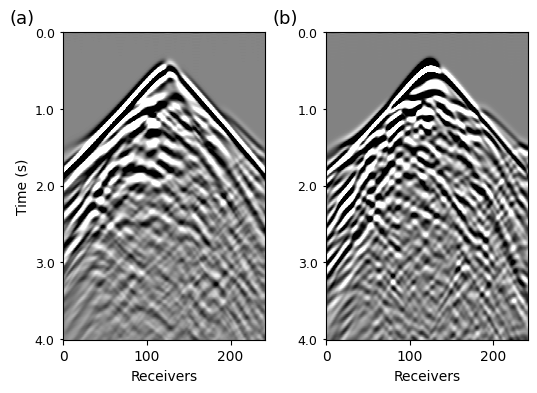

In [22]:
bp_vp = torch.tensor(bp_vp).float().to(DEVICE)
bp_vs = torch.tensor(bp_vs).float().to(DEVICE)
bp_rho = torch.tensor(bp_rho).float().to(DEVICE)
########### 生成正演图像 ###########
out = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(bp_vp, bp_vs,
                                               bp_rho),
    DH, DT,
    source_amplitudes_y=src,
    source_amplitudes_x=src,
    source_locations_y=src_loc,
    source_locations_x=src_loc,
    receiver_locations_y=rec_loc,
    receiver_locations_x=rec_loc,
    pml_freq=F_PEAK,
)

vx = out[15]
vx_label = Downsample(vx,N_RECEIVERS,DEEPWAVE_SIZE)
vx_input = Downsample(vx,N_RECEIVERS,MODEL_INPUT_SIZE)
vy = out[14]
vy_label = Downsample(vy,N_RECEIVERS,DEEPWAVE_SIZE)
vy_input = Downsample(vy,N_RECEIVERS,MODEL_INPUT_SIZE)

taux_vx = (vx_label.cpu()).permute(0, 2, 1)
taux_vy = (vy_label.cpu()).permute(0, 2, 1)
taux_input_vx = (vx_input.cpu()).permute(0, 2, 1)
taux_input_vy = (vy_input.cpu()).permute(0, 2, 1)

  
if taux_vx.shape==taux_vy.shape:
    ns, nt, nr = taux_vx.shape
    print(f"Number of \n{'-'*10}")
    print(f"sources: {ns}\nreceivers: {nr}\nobsvx shape:{taux_vx.shape}\nobsvy shape:{taux_vy.shape}")
        
    vpmin, vpmax = torch.quantile(taux_vx[N_SHOTS//2],
                                 torch.tensor([0.01, 0.99]))
    vsmin, vsmax = torch.quantile(taux_vy[N_SHOTS//2],
                                 torch.tensor([0.01, 0.99]))

gain = 0.3
torch.save(taux_vx,f= obs_path + f"/obs_vx_{N_SHOTS}_{F_PEAK}_{NT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vx,f= obs_path + f"/input_vx_{N_SHOTS}_{F_PEAK}_{NT}_{MODEL_INPUT_SIZE}")
torch.save(taux_vy,f= obs_path + f"/obs_vy_{N_SHOTS}_{F_PEAK}_{NT}_{DEEPWAVE_SIZE}")
torch.save(taux_input_vy,f= obs_path + f"/input_vy_{N_SHOTS}_{F_PEAK}_{MODEL_INPUT_SIZE}")
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(taux_vx[N_SHOTS//2], aspect='auto', cmap='gray',vmin=gain*vpmin, vmax=gain*vpmax)
ax[0].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[0].set_xlabel("Receivers")
ax[0].set_ylabel("Time (s)")
ax[0].set_title('(a)',position=(-0.2,1),fontsize=13)
ax[1].imshow(taux_vy[N_SHOTS//2], aspect='auto', cmap='gray',vmin=gain*vsmin, vmax=gain*vsmax)
ax[1].set_yticks(np.arange(0,NT,50),DT*np.arange(0,NT,50))
ax[1].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[1].set_xlabel("Receivers")
ax[1].set_title('(b)',position=(-0.2,1),fontsize=13)
plt.subplots_adjust(hspace=0.6,wspace=0.3) 
plt.savefig(obs_path+"records.pdf",bbox_inches='tight', dpi=900)  
plt.show()